In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
from datetime import datetime, timedelta
import urllib
import os.path

%matplotlib inline

In [2]:
# Load survey times
survey_time = pd.read_csv("/Users/lachlanphillips/Development/PhD/repos/Eudyptula/data/transects/survey_times.csv")
survey_time['start_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['start_UTC']]
survey_time['end_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['end_UTC']]
survey_time

,id,year,start_UTC,end_UTC
0,2015_S1,2015,2015-09-30 20:35:42,2015-10-07 22:29:08
1,2016_S1,2016,2016-09-15 22:00:37,2016-09-28 03:22:35
2,2016_S2,2016,2016-10-22 03:09:45,2016-11-02 02:27:31
3,2017_S1,2017,2017-08-14 22:34:51,2017-08-26 04:17:06
4,2017_S2,2017,2017-10-02 22:24:52,2017-10-13 05:04:28
5,2018_S1,2018,2018-08-22 22:38:58,2018-09-04 04:42:08
6,2018_S2,2018,2018-09-27 21:54:38,2018-10-01 02:33:09
7,2019_S1,2019,2019-09-24 01:26:33,2019-09-26 02:22:16
8,2019_S2,2019,2019-09-30 21:36:31,2019-10-02 05:57:46


In [3]:
# download data for each day of surveys (only do this once to avoid data consumption)
if False:
    for i, row in survey_time.iterrows():
        # make time series
        dates = pd.date_range(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7))
        
        # download
        for d in dates:
            # SST
            download_url = "https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/"+d.strftime("%Y")+"/"+d.strftime("%Y%m%d")+"032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc"
            fname = "/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc"
            if not os.path.isfile(fname):
                print("Downloading: "+download_url)
                urllib.request.urlretrieve(download_url, fname)
            else:
                print("Already downloaded: "+download_url)
            # ALT can be downloaded manually

# Load data for plot testing
if False:
    for i, row in survey_time.iterrows():
        # make time series
        dates = pd.date_range(row.start_UTC, row.end_UTC + timedelta(days=1))

        for d in dates:
                # load SST data
                sst = xr.open_dataset("/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc")
                # convert from Kelvin
                sst["sst"] = sst.sea_surface_temperature - 273.15

                # Load altimtry (unless already loaded)
                alt_fn = "/Volumes/LP_MstrData/master-data/ocean/IMOS/ALT/IMOS_OceanCurrent_HV_DM01_"+d.strftime("%Y")+".nc"
                alt = xr.open_dataset(alt_fn)

                # Make the plot
                print("loaded "+d.strftime("%Y-%m-%d"))
                
                break

        break


Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2015/20150923032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2015/20150924032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2015/20150925032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2015/20150926032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2015/20150927032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2015/20150928032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3

Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2016/20161019032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2016/20161020032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2016/20161021032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2016/20161022032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2016/20161023032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2016/20161024032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileS

Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2017/20171001032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2017/20171002032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2017/20171003032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2017/20171004032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2017/20171005032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2017/20171006032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au

Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2018/20180927032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2018/20180928032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2018/20180929032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2018/20180930032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Already downloaded: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2018/20181001032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/2018/20181002032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
Downloading: https://thredds.aodn.org.au/thredd

plotting 2015-09-30
plotting 2015-10-01
plotting 2015-10-02
plotting 2015-10-03
plotting 2015-10-04
plotting 2015-10-05
plotting 2015-10-06
plotting 2015-10-07
plotting 2015-10-08
plotting 2016-09-15
plotting 2016-09-16
plotting 2016-09-17
plotting 2016-09-18
plotting 2016-09-19
plotting 2016-09-20
plotting 2016-09-21
plotting 2016-09-22
plotting 2016-09-23
plotting 2016-09-24
plotting 2016-09-25
plotting 2016-09-26


<ipython-input-13-e4d1d050809c>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18,10))


plotting 2016-09-27
plotting 2016-09-28
plotting 2016-10-22
plotting 2016-10-23
plotting 2016-10-24
plotting 2016-10-25
plotting 2016-10-26
plotting 2016-10-27
plotting 2016-10-28
plotting 2016-10-29
plotting 2016-10-30
plotting 2016-10-31
plotting 2016-11-01
plotting 2016-11-02
plotting 2017-08-14
plotting 2017-08-15
plotting 2017-08-16
plotting 2017-08-17
plotting 2017-08-18
plotting 2017-08-19
plotting 2017-08-20
plotting 2017-08-21
plotting 2017-08-22
plotting 2017-08-23
plotting 2017-08-24
plotting 2017-08-25
plotting 2017-08-26
plotting 2017-10-02
plotting 2017-10-03
plotting 2017-10-04
plotting 2017-10-05
plotting 2017-10-06
plotting 2017-10-07
plotting 2017-10-08
plotting 2017-10-09
plotting 2017-10-10
plotting 2017-10-11
plotting 2017-10-12
plotting 2017-10-13
plotting 2018-08-22
plotting 2018-08-23
plotting 2018-08-24
plotting 2018-08-25
plotting 2018-08-26


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x15eb10430> (for post_execute):


KeyboardInterrupt: 

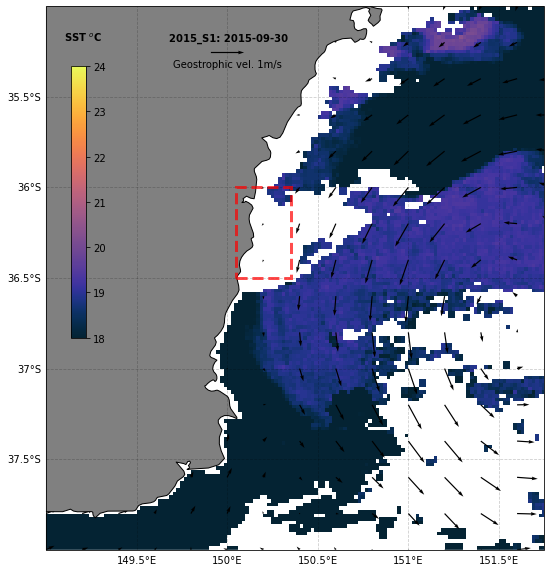

In [ ]:
# Process each day in the survey time set and make a plot
loaded = "none"
for i, row in survey_time.iterrows():
    # make time series
    dates = pd.date_range(row.start_UTC, row.end_UTC + timedelta(days=1))
    
    for d in dates:
            # load SST data
            sst = xr.open_dataset("/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc")
            # convert from Kelvin
            sst["sst"] = sst.sea_surface_temperature - 273.15
            
            # Load altimtry (unless already loaded)
            alt_fn = "/Volumes/LP_MstrData/master-data/ocean/IMOS/ALT/IMOS_OceanCurrent_HV_DM01_"+d.strftime("%Y")+".nc"
            if alt_fn != loaded:
                alt = xr.open_dataset(alt_fn)
                loaded = alt_fn
                
            # Make the plot
            print("plotting "+d.strftime("%Y-%m-%d"))
            
            day = d.strftime("%Y-%m-%d")

            fig = plt.figure(figsize=(18,10))
            ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
            #set coastline
            coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', 
                                                 facecolor='none', name='coastline')
            feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
            im = sst.sst.plot(cmap=cmocean.cm.thermal, add_colorbar=False, vmin=18, vmax=24)
            Q = plt.quiver(alt.LONGITUDE, alt.LATITUDE, alt.UCUR.sel(TIME=day),
                           alt.VCUR.sel(TIME=day), units='width', scale=15)
            extent_ls = [149,151.75,-35,-38]
            ax.set_extent(extent_ls)
            #make pretty gridlines and labels
            gl = ax.gridlines(draw_labels=True, color='black',
                              alpha=0.2, linestyle='--')
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.right_labels = False
            gl.top_labels = False
            plt.text(extent_ls[0]+.1, extent_ls[2]-.19,
                     'SST $^o$C', weight='bold')
            plt.text(extent_ls[0]+.68, extent_ls[2]-.19,
                     row.id+": "+d.strftime("%Y-%m-%d"), weight='bold')

            plt.quiverkey(Q, X=extent_ls[0]+1, Y=extent_ls[2]-.25, U=1,
                          color='black', coordinates='data',
                          label='Geostrophic vel. 1m/s', labelpos='S')
            plt.title(None)

            # add survey area
            ax.add_patch(mpatches.Rectangle(xy=[150.05, -36.5], width=.3, height=.5, linestyle="--",
                                            linewidth=3, zorder=10,
                                            edgecolor='red', fill=False,
                                            alpha=.7,
                                            transform=ccrs.PlateCarree()))

            # colorbar
            cax = inset_axes(ax,
                             width="3%",  # width = 10% of parent_bbox width
                             height="50%",  # height : 50%
                             loc='lower left',
                             bbox_to_anchor=(.05,.39, 1, 1),
                             bbox_transform=ax.transAxes,
                             borderpad=0)
            fig.colorbar(im, cax=cax)
            
            plt.savefig("./figures/SST_ALT/radar_"+row.id+"_"+d.strftime("%Y-%m-%d")+".png",
                        format="png",
                        bbox_inches='tight',
                        pad_inches=0.1, 
                        dpi=300)
            
            

Loading 2015_S1
Plotting 2015_S1
Loading 2016_S1
Plotting 2016_S1
Loading 2016_S2
Plotting 2016_S2
Loading 2017_S1
Plotting 2017_S1
Loading 2017_S2
Plotting 2017_S2
Loading 2018_S1
Plotting 2018_S1
Loading 2018_S2
Plotting 2018_S2
Loading 2019_S1
Plotting 2019_S1
Loading 2019_S2
Plotting 2019_S2


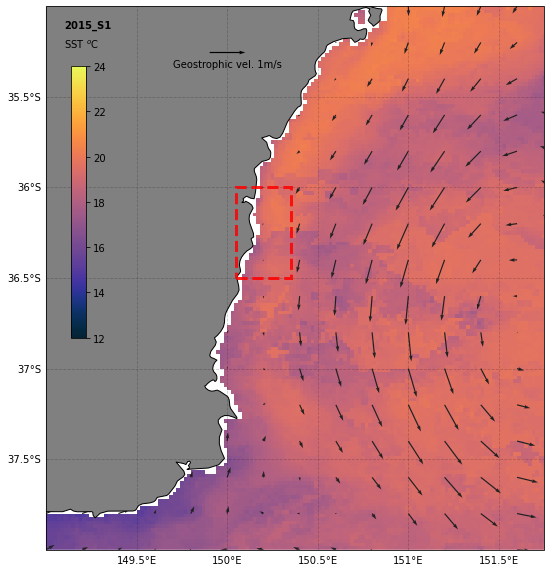

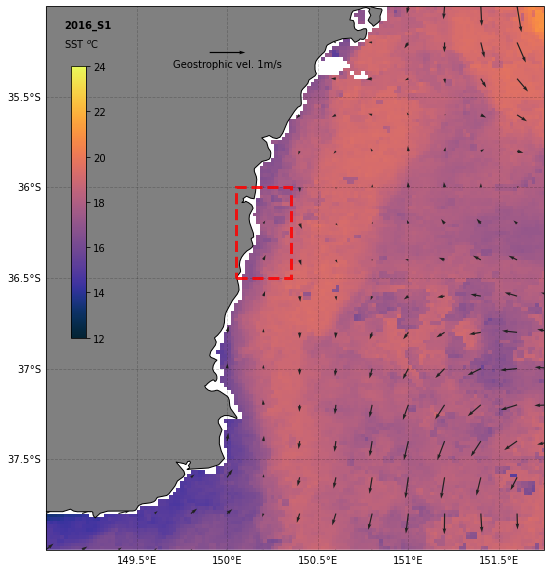

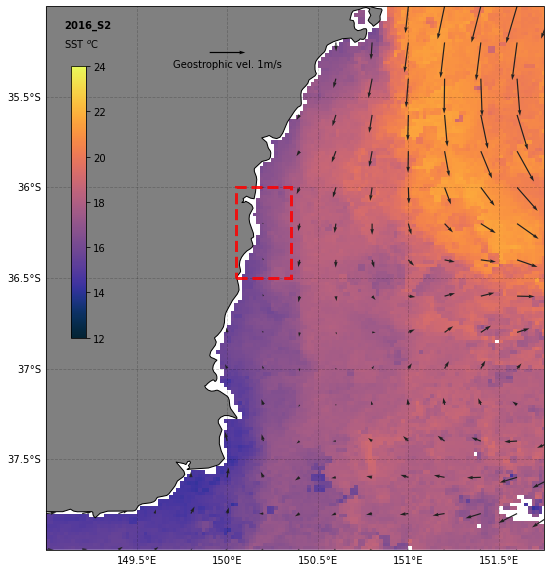

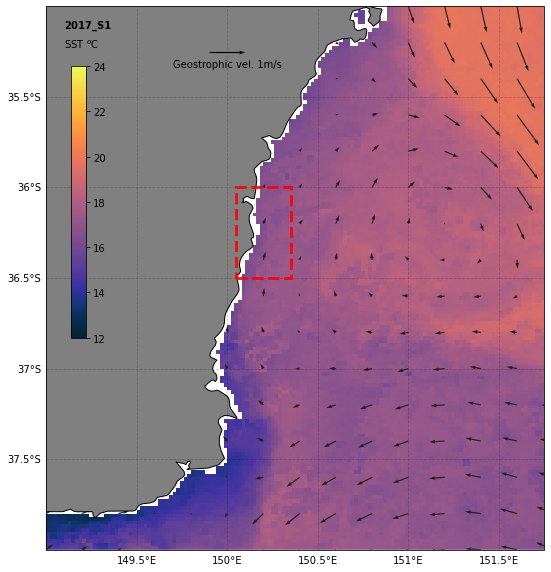

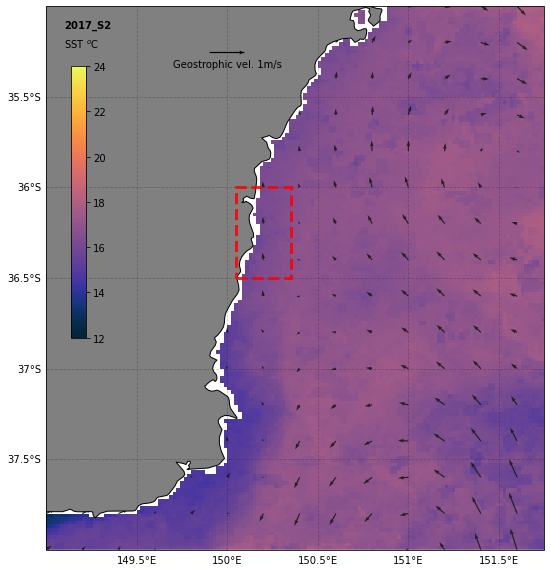

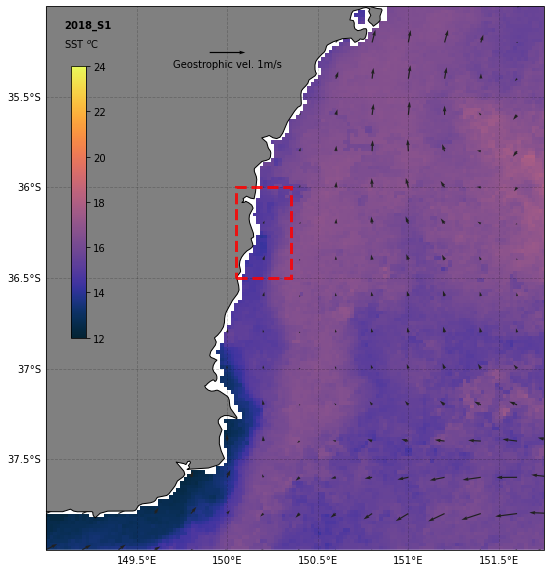

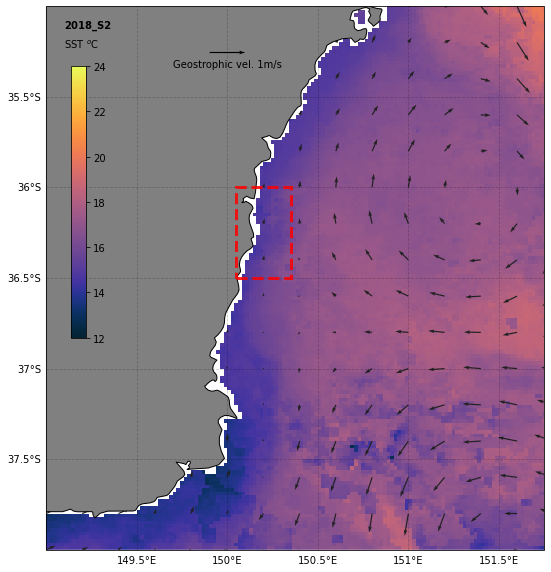

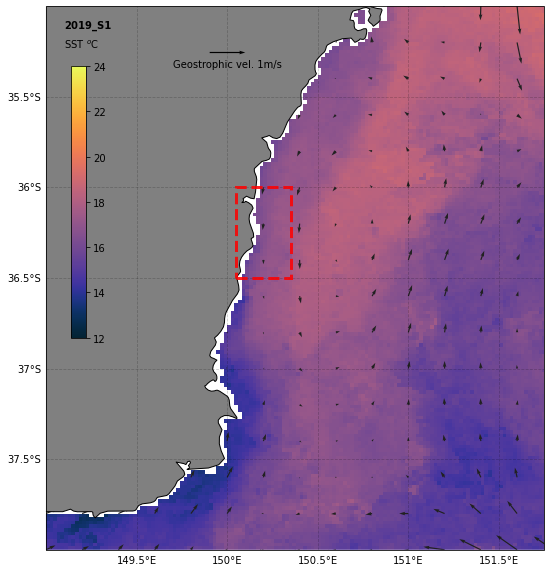

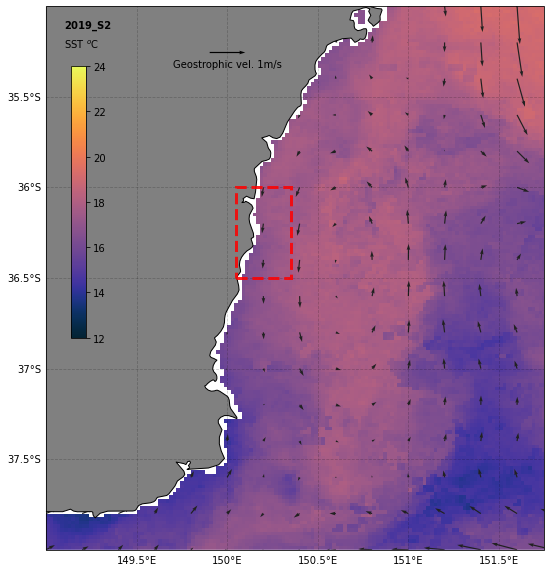

In [73]:
# Composite images
# Process each day in the survey time and merge together by mean
for i, row in survey_time.iterrows():
    print("Loading "+row.id)
    # make time series
    dates = pd.date_range(row.start_UTC - timedelta(days=2), row.start_UTC + timedelta(days=7))
    
    # load SST data for each date
    sst_ls = [xr.open_dataset("/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc") for d in dates]
    # Filter to keep only var of interest (speed things up)
    sst_ls = [sst[['sea_surface_temperature', 'quality_level']] for sst in sst_ls]
    sst = xr.concat(sst_ls, dim="time")
    sst["sst"] = sst.sea_surface_temperature - 273.15
    
    # load ALT data
    alt_fn = "/Volumes/LP_MstrData/master-data/ocean/IMOS/ALT/IMOS_OceanCurrent_HV_DM01_"+dates[0].strftime("%Y")+".nc"
    alt = xr.open_dataset(alt_fn)
    # subset by time
    alt = alt.sel(TIME=slice(dates[0] - timedelta(days=1), dates[-1]))
    # Filter to keep only vars of interest (speed things up)
    alt = alt[["UCUR", "VCUR"]]
    
    # take mean over time
    sst = sst.mean(dim="time")
    alt = alt.mean(dim="TIME")
    
    # __PLOT__
    print("Plotting "+row.id)
    fig = plt.figure(figsize=(18,10))
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())

    #set coastline
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', 
                                         facecolor='none', name='coastline')
    feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
    im = sst.sst.plot(cmap=cmocean.cm.thermal, add_colorbar=False, vmin=12, vmax=24)
    Q = plt.quiver(alt.LONGITUDE, alt.LATITUDE, alt.UCUR,
                   alt.VCUR, units='width', scale=14, color="#212121")
    extent_ls = [149,151.75,-35,-38]
    ax.set_extent(extent_ls)

    # make pretty gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black',
                      alpha=0.2, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False

    # labels
    plt.text(extent_ls[0]+.1, extent_ls[2]-.12,
             row.id, weight='bold')
    plt.text(extent_ls[0]+.1, extent_ls[2]-.23,
             'SST $^o$C',)
    plt.quiverkey(Q, X=extent_ls[0]+1, Y=extent_ls[2]-.25, U=1,
                  color='black', coordinates='data',
                  label='Geostrophic vel. 1m/s', labelpos='S')
    plt.title(None)

    # add survey area
    ax.add_patch(mpatches.Rectangle(xy=[150.05, -36.5], width=.3, height=.5, linestyle="--",
                                    linewidth=3, zorder=10,
                                    edgecolor='red', fill=False,
                                    alpha=.85,
                                    transform=ccrs.PlateCarree()))

    # colorbar
    cax = inset_axes(ax,
                     width="3%",  # width = 10% of parent_bbox width
                     height="50%",  # height : 50%
                     loc='lower left',
                     bbox_to_anchor=(.05,.39, 1, 1),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    fig.colorbar(im, cax=cax)
    
    # Save fig
    plt.savefig("./figures/SST_ALT/composites/composite_"+row.id+".png",
                        format="png",
                        bbox_inches='tight',
                        pad_inches=0.1, 
                        dpi=300)


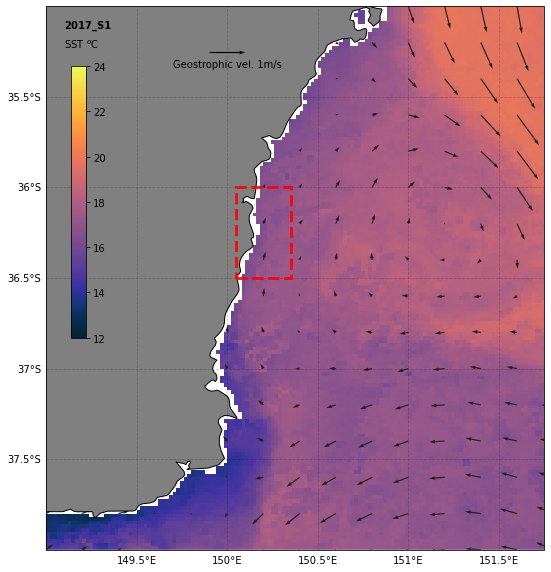

In [72]:
#### Plot TESTING
fig = plt.figure(figsize=(18,10))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())

#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', 
                                     facecolor='none', name='coastline')
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = sst.sst.plot(cmap=cmocean.cm.thermal, add_colorbar=False, vmin=12, vmax=24)
Q = plt.quiver(alt.LONGITUDE, alt.LATITUDE, alt.UCUR,
               alt.VCUR, units='width', scale=14, 
               color='#212121')
extent_ls = [149,151.75,-35,-38]
ax.set_extent(extent_ls)

# make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True, color='black',
                  alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

# labels
plt.text(extent_ls[0]+.1, extent_ls[2]-.12,
         row.id, weight='bold')
plt.text(extent_ls[0]+.1, extent_ls[2]-.23,
         'SST $^o$C',)
plt.quiverkey(Q, X=extent_ls[0]+1, Y=extent_ls[2]-.25, U=1,
              color='black', coordinates='data',
              label='Geostrophic vel. 1m/s', labelpos='S')
plt.title(None)

# add survey area
ax.add_patch(mpatches.Rectangle(xy=[150.05, -36.5], width=.3, height=.5, linestyle="--",
                                linewidth=3, zorder=10,
                                edgecolor='red', fill=False,
                                alpha=.85,
                                transform=ccrs.PlateCarree()))

# colorbar
cax = inset_axes(ax,
                 width="3%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
fig.colorbar(im, cax=cax)
